# Classification

## Objectives

*   Fit and evaluate a deep learning classification model to predict if a treatment will be successful or not.


## Inputs

* outputs/datasets/collection/FertilityTreatmentData.csv.gz
* Instructions from the notebooks 02 and 04 on which variables to use for data cleaning and feature engineering.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Machine learning model creation and training
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on random data


---

## Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-predictor/jupyter_notebooks'

To make the parent of the current directory the new current directory:
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("A new current directory has been set")

A new current directory has been set


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-predictor'

---

## Load Data

In [4]:
import numpy as np
import pandas as pd

# Open dataset
df = pd.read_csv("outputs/datasets/cleaned/FertilityTreatmentDataCleaned.csv.gz")
        
print(df.shape)
df.head(3)

(135695, 29)


,Patient age at treatment,Total number of previous IVF cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,Stimulation used,...,Frozen cycle,Fresh eggs collected,Total eggs mixed,Total embryos created,Embryos transferred,Total embryos thawed,Embryos transferred from eggs micro-injected,Date of embryo transfer,Live birth occurrence,Patient ethnicity
0,18-34,0,0,0,0,0,1,0,0,1,...,0,1-5,1-5,1-5,1e,0 - fresh cycle,1,5 - fresh,0,White
1,18-34,1,0,0,0,0,1,0,0,0,...,1,0 - frozen cycle,0 - frozen cycle,0 - frozen cycle,1,1-5,0,0 - frozen,0,White
2,40-42,0,0,0,0,0,0,1,0,1,...,0,1-5,1-5,1-5,1,0 - fresh cycle,0,3 - fresh,0,White


---

## Set output directory

In [5]:
import joblib
import os

version = "v1"
file_path = f"outputs/ml_pipeline_dl/ivf_success_predictor_dl/{version}"

try:
    # Check if the directories exist
    if os.path.exists(file_path):
        print("Old version is already available. Please create a new version.")
    else:
        # Create the directory if it does not exist
        os.makedirs(name=file_path)
        print(f"Directory {file_path} created successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory outputs/ml_pipeline_dl/ivf_success_predictor_dl/v1 created successfully.


---

## ML Pipeline

Custom Transformers:

### Preprocessing Pipeline

For the deep learning model, all categorical variables were encoded using One-Hot Encoding to avoid implicit ordinal relationships, ensuring the model does not misinterpret any order among categorical values, which could lead to learning non-existent relationships.

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder


def PreprocessingPipelineDL():
    pipeline_base = Pipeline(
        [
            (
                "one_hot_encoding",
                OneHotEncoder(
                    drop_last=True,
                    variables=[
                        "Patient age at treatment",
                        "Total number of previous IVF cycles",
                        "Patient/Egg provider age",
                        "Partner/Sperm provider age",
                        "Specific treatment type",
                        "Egg source",
                        "Sperm source",
                        "Patient ethnicity",
                        "Fresh eggs collected",
                        "Total eggs mixed",
                        "Total embryos created",
                        "Embryos transferred",
                        "Total embryos thawed",
                        "Date of embryo transfer",
                    ],
                ),
            ),
            (
                "smart_correlation",
                SmartCorrelatedSelection(
                    method="spearman", threshold=0.9
                ),
            ),
        ]
    )

    return pipeline_base


PreprocessingPipelineDL()

Pipeline(steps=[('one_hot_encoding',
                 OneHotEncoder(drop_last=True,
                               variables=['Patient age at treatment',
                                          'Total number of previous IVF cycles',
                                          'Patient/Egg provider age',
                                          'Partner/Sperm provider age',
                                          'Specific treatment type',
                                          'Egg source', 'Sperm source',
                                          'Patient ethnicity',
                                          'Fresh eggs collected',
                                          'Total eggs mixed',
                                          'Total embryos created',
                                          'Embryos transferred',
                                          'Total embryos thawed',
                                          'Date of embryo transfer'])),
                ('smart_correlation',
                 SmartCorrelatedSelection(method='spearman', threshold=0.9))])

---

## Sequential model (Deep Learning)

### Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split

# Define the features (X) and target (y)
X = df.drop(columns=["Live birth occurrence"])  # Drop the target column from the features
y = df["Live birth occurrence"]  # Define the target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,               # Features DataFrame
    y,               # Target Series
    test_size=0.2,   # 20% of the data will be used for testing
    random_state=0   # Set a random state for reproducibility
)


Apply the preprocessing pipeline

In [8]:
X_train.head(3)

,Patient age at treatment,Total number of previous IVF cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,Stimulation used,...,Fresh cycle,Frozen cycle,Fresh eggs collected,Total eggs mixed,Total embryos created,Embryos transferred,Total embryos thawed,Embryos transferred from eggs micro-injected,Date of embryo transfer,Patient ethnicity
37915,18-34,4,1,1,0,1,1,0,0,0,...,0,1,0 - frozen cycle,0 - frozen cycle,0 - frozen cycle,1e,1-5,1,0 - frozen,Other
112081,18-34,1,0,0,0,0,0,0,0,1,...,1,0,11-15,11-15,6-10,1e,0 - fresh cycle,0,5 - fresh,White
83821,18-34,0,0,0,0,0,1,0,0,1,...,1,0,6-10,6-10,1-5,2,0 - fresh cycle,2,3 - fresh,White


In [9]:
pipeline_feat_eng_dl = PreprocessingPipelineDL()
X_train = pipeline_feat_eng_dl.fit_transform(X_train)

In [10]:
X_train.head(3)

,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,PGT-M treatment,PGT-A treatment,Embryos transferred from eggs micro-injected,...,Date of embryo transfer_2 - frozen,Date of embryo transfer_6 - frozen,Date of embryo transfer_0 - fresh,Date of embryo transfer_1 - fresh,Date of embryo transfer_3 - Mixed fresh/frozen,Date of embryo transfer_5 - frozen,Date of embryo transfer_7 - fresh,Date of embryo transfer_2 - Mixed fresh/frozen,Date of embryo transfer_5 - Mixed fresh/frozen,Date of embryo transfer_6 - Mixed fresh/frozen
37915,1,1,0,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
112081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83821,0,0,0,0,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


Apply the pipeline to the test set

In [11]:
X_test = pipeline_feat_eng_dl.transform(X_test)

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(108556, 91) (108556,) (27139, 91) (27139,)


Check Train Set Target distribution

0    77581
1    30975
Name: Live birth occurrence, dtype: int64


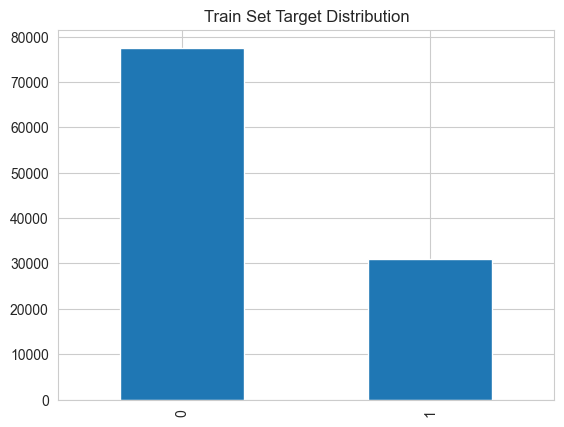

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_train.value_counts())

sns.set_style("whitegrid")
y_train.value_counts().plot(kind="bar", title="Train Set Target Distribution")
plt.show()

## Handle Target Imbalance

### Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [14]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(155162, 91) (155162,) (27139, 91) (27139,)


Check Train Set Target distribution after resampling

0    77581
1    77581
Name: Live birth occurrence, dtype: int64


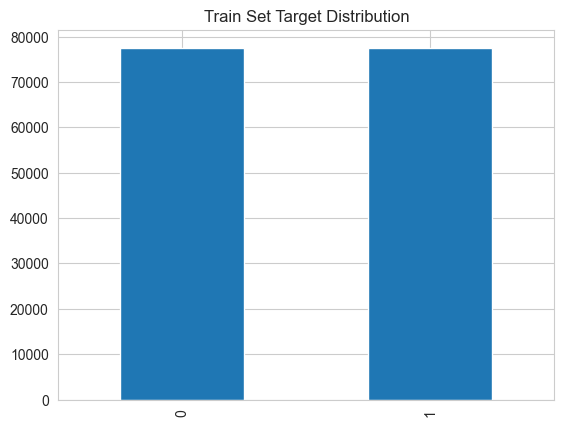

In [15]:
import matplotlib.pyplot as plt

print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Further split Train set to validation and Train set

In [16]:
from sklearn.model_selection import train_test_split

# Create new training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train, y_train,
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)


* Train set: (124129, 91) (124129,)
* Validation set: (31033, 91) (31033,)
* Test set: (27139, 91) (27139,)


---

### Push to Repo

#### Train Set

In [17]:
X_train.to_csv(f"{file_path}/X_train.csv.gz", index=False, compression="gzip")

In [18]:
y_train.to_csv(f"{file_path}/y_train.csv.gz", index=False, compression="gzip")

#### Test Set

In [19]:
X_test.to_csv(f"{file_path}/X_test.csv.gz", index=False, compression="gzip")

In [20]:
y_test.to_csv(f"{file_path}/y_test.csv.gz", index=False, compression="gzip")

#### Validation Set

In [21]:
X_test.to_csv(f"{file_path}/X_test.csv.gz", index=False, compression="gzip")

In [22]:
y_test.to_csv(f"{file_path}/y_test.csv.gz", index=False, compression="gzip")

---

### Scale Features

In [23]:
from sklearn.preprocessing import StandardScaler


def PipelineScale():
    pipeline_base = Pipeline([("feat_scaling", StandardScaler())])

    return pipeline_base

In [24]:
pipeline_scale = PipelineScale() 

# Fit the pipeline on the training data
# Fit and transform the training set
X_train = pipeline_scale.fit_transform(X_train)  

# Use the fitted pipeline to transform the validation and test sets
# Transform validation set
X_val = pipeline_scale.transform(X_val)
# Transform test set
X_test = pipeline_scale.transform(X_test)  


X_train[:2,]

array([[-4.52432245e-01, -4.03323207e-01, -3.14212997e-01,
        -3.50270069e-01, -7.09885678e-01, -6.46530220e-01,
        -2.26394986e-01, -9.93818097e-02, -1.09548828e-01,
        -6.73630139e-01,  1.14000968e+00, -5.50168675e-01,
        -3.63653155e-01, -3.91896770e-01, -1.81720559e-01,
        -2.04740889e-01,  1.68894790e+00, -7.59408827e-01,
        -2.89094405e-01, -1.48237352e-01, -1.77804324e-01,
        -1.56296803e-01, -3.79367324e-01,  1.35065126e+00,
        -4.85747561e-01, -2.46365407e-01, -3.00969128e-01,
        -1.37522268e-01, -3.63681555e-01, -7.68610272e-02,
        -7.89010569e-01, -6.90324900e-01,  1.57230400e+00,
        -4.39218702e-02, -1.77281701e-02,  2.59455744e-01,
         3.17206219e-01, -4.34096844e-01,  6.74360243e-01,
        -3.28269012e-01, -1.37856388e-01, -3.96969806e-01,
        -4.93094597e-01, -3.90651144e-01, -1.53570613e-01,
        -2.44391033e-01, -2.59703254e-01, -8.57468569e-02,
        -4.72920753e-02, -2.93726090e-02, -3.81739534e-0

---

# Model creation

## ML model

Define early stopping callback

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=20,
    restore_best_weights=True,  
    monitor='val_accuracy',
    verbose=1, 
    mode='max' 
)

### Define deep learning model

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

input_shape = X_train.shape[1:]

def create_dl_model(input_shape):
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        # First hidden layer with 64 neurons and a dropout rate of 0.5
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        # Second hidden layer with 32 neurons and a dropout rate of 0.5
        Dense(32, activation='relu'),
        Dropout(0.5),
        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Model Summary 

In [27]:
dl_model = create_dl_model(input_shape)
dl_model.summary()

/Users/patriciahalley/Documents/Code_institute/git/ivf-predictor/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-08 02:12:22.431674: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-08 02:12:22.431708: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-08 02:12:22.431720: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-08 02:12:22.431778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-08 02:12:22.431797: I tensorflow/core/common_runtime/pluggable_devi

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,145 (86.50 KB)

 Trainable params: 22,145 (86.50 KB)

 Non-trainable params: 0 (0.00 B)

Train deep learning model

In [28]:
dl_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


2024-09-08 02:12:22.914168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3880/3880 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.6195 - loss: 0.6454 - val_accuracy: 0.6944 - val_loss: 0.5657
Epoch 2/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.6927 - loss: 0.5647 - val_accuracy: 0.7103 - val_loss: 0.5374
Epoch 3/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.7073 - loss: 0.5455 - val_accuracy: 0.7094 - val_loss: 0.5354
Epoch 4/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.7093 - loss: 0.5395 - val_accuracy: 0.7151 - val_loss: 0.5264
Epoch 5/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 109s 28ms/step - accuracy: 0.7148 - loss: 0.5357 - val_accuracy: 0.7179 - val_loss: 0.5241
Epoch 6/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - accuracy: 0.7138 - loss: 0.5343 - val_accuracy: 0.7171 - val_loss: 0.5232
Epoch 7/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.7148 - loss: 0.5321 - val_accuracy: 0.7217 - val_loss: 0.5195
Epoch 8/100
3880/3880 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.7201 - loss

---

## Model Performace

### Model learning curve

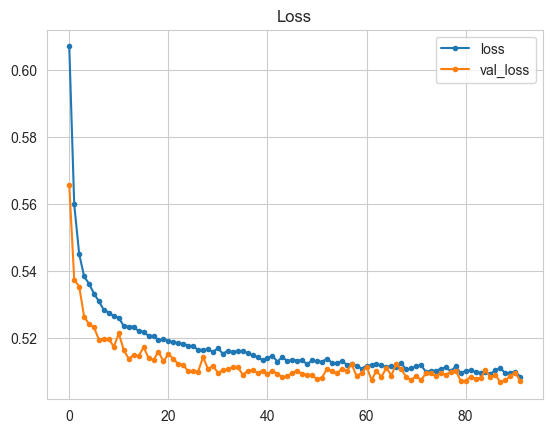

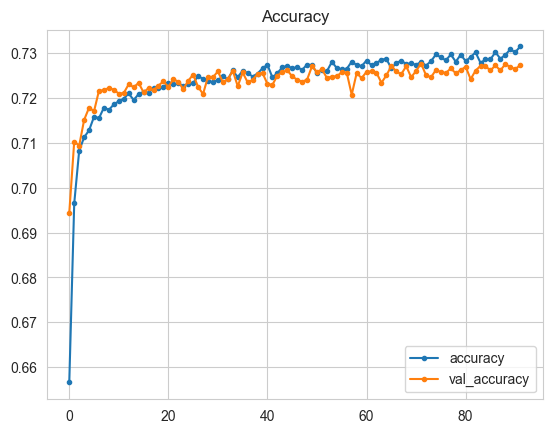

In [29]:
losses = pd.DataFrame(dl_model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/dl_model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/dl_model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

 ### Model Evaluation

Evaluate model on test set

In [30]:
evaluation = dl_model.evaluate(X_test,y_test)
evaluation

849/849 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6433 - loss: 0.5956


[0.5951253771781921, 0.6432071924209595]

### Confusion matrix

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import pandas as pd

def confusion_matrix_and_report(X, y, pipeline, label_map):
    # Get predictions from the pipeline
    prediction = pipeline.predict(X).reshape(-1)
    
    # Apply thresholding if prediction outputs probabilities
    prediction = np.where(prediction < 0.5, 0, 1)

    # Print confusion matrix
    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=y, y_pred=prediction), 
            columns=["Actual " + label for label in label_map],
            index=["Predicted " + label for label in label_map]
        )
    )
    print("\n")

    # Print classification report
    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")

    # Calculate F1 scores
    f1_scores = f1_score(y, prediction, average=None)
    mean_f1_score = f1_scores.mean()
    
    # Print F1 scores with two decimal places
    f1_scores_rounded = {label: round(score, 2) for label, score in zip(label_map, f1_scores)}
    mean_f1_score_rounded = round(mean_f1_score, 2)
    
    print(f"F1 Score for each class: {f1_scores_rounded}")
    print(f"Mean F1 Score: {mean_f1_score_rounded}\n")


def clf_performance(X_train, y_train, X_test, y_test, X_val, y_val, pipeline, label_map):
    # Evaluate on Train Set
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    # Evaluate on Validation Set
    print("#### Validation Set #### \n")
    confusion_matrix_and_report(X_val, y_val, pipeline, label_map)

    # Evaluate on Test Set
    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


In [32]:
clf_performance(X_train, y_train,
                X_test,y_test,
                X_val, y_val,
                dl_model,
                label_map= ['No Success', 'Success']
                )

#### Train Set #### 

3880/3880 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
---  Confusion Matrix  ---
                      Actual No Success  Actual Success
Predicted No Success              45804           16304
Predicted Success                 16018           46003


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.74      0.74      0.74     62108
     Success       0.74      0.74      0.74     62021

    accuracy                           0.74    124129
   macro avg       0.74      0.74      0.74    124129
weighted avg       0.74      0.74      0.74    124129
 

F1 Score for each class: {'No Success': 0.74, 'Success': 0.74}
Mean F1 Score: 0.74

#### Validation Set #### 

970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
---  Confusion Matrix  ---
                      Actual No Success  Actual Success
Predicted No Success              11187            4286
Predicted Success                  4164           11396


---  Classification Report 

---

## Predict on new data

Predict class probabilities

Print the 50 first rows to choose samples to manually test the model. Live birth occurence 0 or 1 would be 0 or 1 on the the final array as it would translate to "No Success" and "Success" respectively.

In [33]:
df["Live birth occurrence"].head(50)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     1
9     1
10    1
11    0
12    0
13    0
14    0
15    0
16    1
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    1
26    0
27    0
28    0
29    0
30    1
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    1
43    0
44    0
45    1
46    0
47    1
48    1
49    0
Name: Live birth occurrence, dtype: int64

Take a sample from the test set and use it as if it was live data.

Choose a index from the dataset that should result in "No Sucess", i. e. Live birth occurrence 0 to test

In [34]:
# Set a specific row of data as the index value 
index = 9

# Extract a specific row from the X_test dataset using the index with the slice method
# The row extracted corresponds to the value of `index-1` to `index`.
# That means if `index` is 1, the row extracted will be the first row of the dataset
# (from index-1, which is 0, to index, which is 1 and 1 is not includded).
# The comma after `index-1:index` keeps the row in a 2D array format (like a single row in a matrix).
live_data = X_test[index-1:index,]

# Display the extracted data.
live_data

array([[-4.52432245e-01, -4.03323207e-01, -3.14212997e-01,
        -3.50270069e-01,  1.40867753e+00, -6.46530220e-01,
        -2.26394986e-01,  1.00622036e+01, -1.09548828e-01,
        -6.73630139e-01,  1.14000968e+00, -5.50168675e-01,
        -3.63653155e-01, -3.91896770e-01, -1.81720559e-01,
        -2.04740889e-01,  1.68894790e+00, -7.59408827e-01,
        -2.89094405e-01, -1.48237352e-01, -1.77804324e-01,
        -1.56296803e-01, -3.79367324e-01,  1.35065126e+00,
        -4.85747561e-01, -2.46365407e-01, -3.00969128e-01,
        -1.37522268e-01, -3.63681555e-01, -7.68610272e-02,
        -7.89010569e-01, -6.90324900e-01,  1.57230400e+00,
        -4.39218702e-02, -1.77281701e-02,  2.59455744e-01,
         3.17206219e-01,  2.30363343e+00, -1.48288694e+00,
        -3.28269012e-01, -1.37856388e-01, -3.96969806e-01,
        -4.93094597e-01, -3.90651144e-01, -1.53570613e-01,
        -2.44391033e-01, -2.59703254e-01, -8.57468569e-02,
        -4.72920753e-02, -2.93726090e-02, -3.81739534e-0

Use model.predict and pass the data

In [35]:
prediction_proba = dl_model.predict(live_data)
prediction_proba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[0.4647404]], dtype=float32)

Set threshold using NumPy function np.where().

Make a condition: (prediction_proba < 0.5), if that is true, it converts to 0; otherwise, it is 1.

In [36]:
prediction_class = np.where(prediction_proba<0.5,0,1)
prediction_class

array([[0]])

In this case, 0 means "No success" and 1 means "Success".

---

### ML Pipelines (Feat Eng, scaling) and Model

Both pipelines should be used in conjunction to predict Live Data.

* To predict on Train Set, Test Set we use only pipeline_scale, since the data is already processed.

#### Save Pipeline responsible for Feature Engineering (One Hot Encoding and Smart Correlation)

In [37]:
pipeline_feat_eng_dl

Pipeline(steps=[('one_hot_encoding',
                 OneHotEncoder(drop_last=True,
                               variables=['Patient age at treatment',
                                          'Total number of previous IVF cycles',
                                          'Patient/Egg provider age',
                                          'Partner/Sperm provider age',
                                          'Specific treatment type',
                                          'Egg source', 'Sperm source',
                                          'Patient ethnicity',
                                          'Fresh eggs collected',
                                          'Total eggs mixed',
                                          'Total embryos created',
                                          'Embryos transferred',
                                          'Total embryos thawed',
                                          'Date of embryo transfer'])),
                ('smart_correlation',
                 SmartCorrelatedSelection(method='spearman', threshold=0.9))])

In [38]:
import joblib
import gzip

# Save the model directly into a compressed gzip file
with gzip.open(f"{file_path}/clf_pipeline_feat_eng_dl.pkl.gz", 'wb') as f_out:
    joblib.dump(pipeline_feat_eng_dl, f_out)

 #### Save Pipeline responsible for Feature Scaling

In [39]:
pipeline_scale

Pipeline(steps=[('feat_scaling', StandardScaler())])

In [40]:

with gzip.open(f"{file_path}/clf_pipeline_scale.pkl.gz", 'wb') as f_out:
    joblib.dump(pipeline_scale, f_out)

### Save the model as pkl compressed

In [41]:
dl_model.save(f"{file_path}/ivf_success_predictor_dl_model.keras")

---

### Save evaluation pickle

In [42]:
import joblib
import gzip

with gzip.open(f"{file_path}/evaluation.pkl.gz", 'wb') as f_out:
    joblib.dump(evaluation, f_out)